<a href="https://colab.research.google.com/github/olegtyulyaev/--2/blob/main/Attestation_2_semestr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Задача №1

Проанализируйте конкурентов на рынке (SkyEng, Lingvoleo и прочие) и сформулируйте гипотезу по улучшению первого экрана лендинга (https://english22.tilda.ws)

**Решение:**

* *Гипотеза 1.* Увеличение скорости загрузки на 20% приведет к снижению показателя отказов на 15%.
* *Гипотеза 2.* Добавление заметной кнопки с призывом к действию в верхней части страницы увеличит CTR на 25%.
* *Гипотеза 3.* Внедрение персонализированных рекомендаций по контенту повысит вовлеченность пользователей на 30%.
* *Гипотеза 4.* Включение элементов социального доказательства может повысить коэффициент конверсии на 20%.
* *Гипотеза 5.* Внедрение A/B-тестирования и итераций на основе отзывов пользователей приведет к увеличению удержания пользователей на 10% через 3 месяца.


## Задача №2

* Подведите результаты эксперимента в экселе по следующим данным: ab_stats.csv
* Стат значимо ли отличается ARPPU в двух группах?
* Какие рекомендации дадите менеджеру?

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns


from scipy.stats import norm, t, kstest, shapiro
import statsmodels.api as sm
from matplotlib import pyplot as plt

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.stats.power import TTestIndPower

import scipy.stats as stats
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [ ]:
df = pd.read_csv('ab_stats.csv')
df.head(15)

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
5,0.0,0,0,A,9.578727
6,0.0,0,0,A,6.162601
7,0.0,0,0,A,11.909452
8,0.0,0,0,A,6.540910
9,0.0,0,0,A,7.990794


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


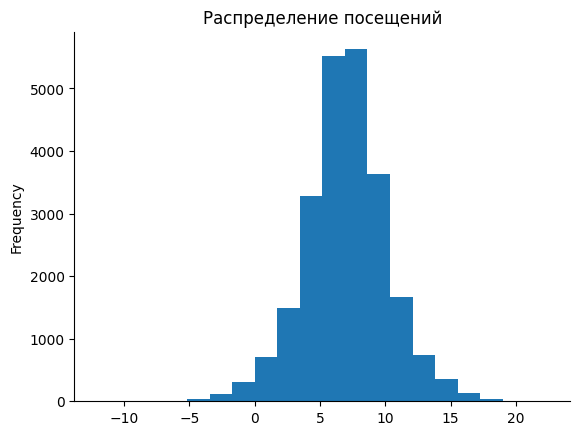

In [ ]:
from matplotlib import pyplot as plt
df['av_site visit'].plot(kind='hist', bins=20, title='Распределение посещений')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Оценим базовую статистику датасета
df.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


По посещаемости и графически и статистически видны нелогичные минуса, вплоть до -12

In [ ]:
# Исключение записей о пользователях, которые дали минусы
df = df.drop(df.loc[df['av_site visit']<0].index)

In [ ]:
# Посмотрим как поменялась статистика после чистки
df.describe()

,revenue,num_purchases,purchase,av_site visit
count,23184.000000,23184.000000,23184.000000,23184.000000
mean,0.326511,0.043780,0.020704,7.188254
std,9.645839,1.089462,0.142394,2.924011
min,0.000000,0.000000,0.000000,0.008679
25%,0.000000,0.000000,0.000000,5.314379
50%,0.000000,0.000000,0.000000,7.068656
75%,0.000000,0.000000,0.000000,8.910900
max,1303.609284,152.000000,1.000000,22.446822


Вычистилось 468 записей или 1,97% выборки. Не критично по объему, но надо разобраться какие данные давали минуса, чтобы в следуюзих жкспериментах сразу было меньше шума.

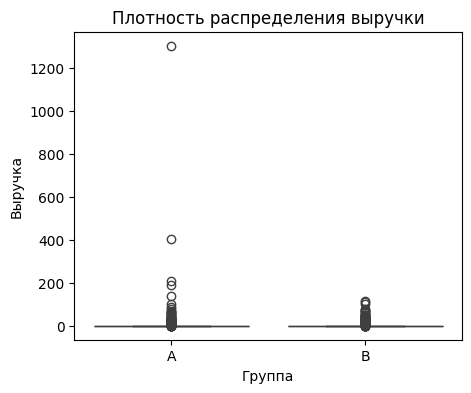

In [ ]:
# Визуализация данных по выручке, с учетом очищенных данных
plt.figure(figsize=(5,4))
ab_net = sns.boxplot(data= df, x='ab_group', y='revenue')
plt.title('Плотность распределения выручки')
plt.ylabel('Выручка')
plt.xlabel('Группа')
plt.show()

В группе А наблюдаются выносы по выручке, возможно сэмплирование не очень качественное было

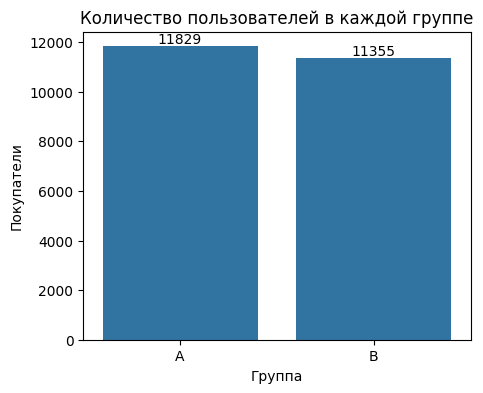

In [ ]:
# визуализация наполненности исследуемых групп после очистки данных
plt.figure(figsize=(5,4))
ab_players = sns.countplot(data=df, x='ab_group')
plt.title('Количество пользователей в каждой группе')
plt.ylabel('Покупатели')
plt.xlabel('Группа')
ab_players.bar_label(ab_players.containers[0])
plt.show()

In [ ]:
# подготовка данных для проверки через Z-тест

k1 = df[df['ab_group']=='A'] ['revenue'].sum()
k2 = df[df['ab_group']=='B']['revenue'].sum()
K1 = df[df['ab_group']=='A'] ['num_purchases'].sum()
K2 = df[df['ab_group']=='B']['num_purchases'].sum()
n1 = df[df['ab_group']=='A'].shape[0]
n2 = df[df['ab_group']=='B'].shape[0]

In [ ]:
# Z-тест на revenue (по выручке)

z_score, z_pvalue = proportions_ztest(np.array([k1, k2]), np.array([n1, n2]))
print('Результаты:','z_score = %.3f, pvalue = %.3f'%(z_score, z_pvalue))

if abs(z_pvalue) > 0.05:
   print('Принимается Н0-гипотеза - Между конверсией в двух группах нет статистически значимых различий')
else:
   print('Принимается Н1-гипотеза – Между конверсией в двух группах есть статистически значимые различия')

Результаты: z_score = 25.901, pvalue = 0.000
Принимается Н1-гипотеза – Между конверсией в двух группах есть статистически значимые различия


In [ ]:
# Z-тест на num_purchases (по количеству покупок)

z_score, z_pvalue = proportions_ztest(np.array([K1, K2]), np.array([n1, n2]))
print('Результаты:','z_score = %.3f, pvalue = %.3f'%(z_score, z_pvalue))

if abs(z_pvalue) > 0.05:
   print('Принимается Н0-гипотеза - Между конверсией в двух группах нет статистически значимых различий')
else:
   print('Принимается Н1-гипотеза – Между конверсией в двух группах есть статистически значимые различия')

Результаты: z_score = 5.273, pvalue = 0.000
Принимается Н1-гипотеза – Между конверсией в двух группах есть статистически значимые различия


In [ ]:
# Статистика по revenue
revenue = df.groupby(['ab_group'])['revenue'].mean()*100
revenue.round(2)

ab_group
A    40.47
B    24.51
Name: revenue, dtype: float64

In [ ]:
# Статистика по num_purchases
purchases = df.groupby(['ab_group'])['num_purchases'].mean()*100
purchases.round(2)

ab_group
A    5.07
B    3.65
Name: num_purchases, dtype: float64

In [ ]:
# ARPU в группе А
ARPU_A = df[df['ab_group']=='A'] ['revenue'].sum() / 11829
ARPU_A.round(5)

0.40467

In [ ]:
# ARPU в группе В
ARPU_B = df[df['ab_group']=='B'] ['revenue'].sum() / 11829
ARPU_B.round(5)

0.23527

**ОБЩИЕ ВЫВОДЫ**

*   Данные надо почистить от отрицательных посещений сайта. Плотность распределения выручки после очистки имеет стат выбросы в выборке А, надо посмотреть еще раз методику сэмплирования данных.

*   А/B тестирование клиентского поведения в группах «А» и «B» показало, что и по параметру выручка и по параметру группа А смотрится лучше, средняя выручка в группе А на 65% больше, а количество покупок на 38%. Z-тесты по обоим метрикам также показали наличие статистически значимых различий в группах.

*   ARPU как итог в группе А также на 65% выше

***Итого экспериментировать нет смысла, т.к. наблюдаемая статистика в контрольной группе лучше, причем и по ARPU и по количеству покупок***


## Задача №3

Мы хотим провести А/Б-тест для трех источников трафика. Нынешняя конверсия равна 5%, мы ожидаем прирост в 0,2%. Уровень доверия 97% и уровень мощности 87%.
Всего на наш продукт заходит 40 000 пользователей в месяц.

* За сколько дней мы сможем протестировать гипотезу? И что вы можете посоветовать по результатам подсчета?

* Допустим в задаче нет проблемы с количеством посетителей на сайт, тогда подведите результаты тестирования, если у нас следующие результаты по количеству конверсии:

25000

30000

32000

## Задача №4

Вы решили сравнивать метрику CPA в двух группах. Размер выборки - 2350 элементов в каждой группе. Для проверки нормальности распределения на выборке в 2350 наблюдений применили , критерий Шапиро-Уилка и получили p-value, равный 0.00002, alpha = 5%.

* Какой бы вывод мы могли сделать в данном случае?
* В этом случае какой статистический критерий для проверки первоначальной гипотезы тут лучше всего подойдёт и почему?

## Задача №5

Мы провели АБ-тест на увеличение average timespent per user. По итогам тестирования мы получили следующие данные. Является ли результат статистически значимым с уровнем доверия 80%? Какую версию мы выкатим на продакшн?

А) Средняя - 360, отклонение - 40, количество - 9802

B) Средняя - 352, отклонение - 58, количество - 9789

## Задача №6

Создайте техническую архитектуру проекта по аб тестированию продукта он-лайн кинотеатра с учетом кросс-девайс аналитики по следующей гипотезе:

Если договориться с банком о 99% кэшбэке на подписку первого месяца, то это повысит конверсию в подписку на 30%, благодаря упрощенному принятию решения со стороны пользователя.

На схеме необходимо отобразить:

1) Управленческий процесс по договоренностям с внешними партнерами

2) Архитектуру данных с указанием систем, из которых будем скачивать данные

3) Внутрикомандное взаимодействие